In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

import pyTigerGraph
pyTigerGraph.__path__

['/home/tigergraph/conda/lib/python3.9/site-packages/pyTigerGraph']

# Recommender System with GNNs on PyG
Dataset: LastFM (based: [JODIE: Predicting Dynamic Embedding Trajectory in Temporal Interaction Networks](http://snap.stanford.edu/jodie/))
GNN Model: LightGCN [\[2002.02126\] LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation](https://arxiv.org/abs/2002.02126)

### Connect to TigerGraph

In [2]:
from pyTigerGraph import TigerGraphConnection

conn = TigerGraphConnection(
    host="http://127.0.0.1", # Change the address to your database server's
    graphname="LastFM",  # Specify LastFM dataset
    username="tigergraph",
    password="tigergraph"
)

In [3]:
%%time
# Basic metadata about the graph such as schema.
# print(conn.gsql("ls"))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [4]:
print("Vertex Count:", conn.getVertexCount('*'))
print("Edge Count:", conn.getEdgeCount('*'))

Vertex Count: {'User': 980, 'Item': 1000}
Edge Count: {'Interact': 154993}


(Custimization Point for pyTigerGraph)
 In order to handle bipartite graphs which is comprised of users and items, we explicty specify # of users and items - which is required to compute the similarty score between user embeddings and items embeddings in GNN models.  To create a matrix for users/items embedding, we need to know # of users and items.  To that end. pyTigerGraph should support functions or attributes to extract these numbers for bipartite graphs - by propopsing two functions - tgraph.number_of_source_vertices(), tgraph.number_of_target_vertices(). These proposed methods should be used for general graphs as long as we target recommendation tasks.

In [5]:
num_users, num_items = conn.getVertexCount("User"), conn.getVertexCount("Item")
num_nodes = num_users + num_items

(Not needed for Recommender Systems since this is based on nodes !!) ### Train/validation/test split by nodes

In recommendation tasks, the input dataset must be split by edges instead of nodes. pyTigerGraph supports node masking to split dataset, but edge masking and custom functions, which extract subgraphs with specified set of edges (training / validation / testing edges ), should be also provided.

In [6]:
%%time
# Train : Val : Test = 70 : 15 : 15 (4 : 1 : 1 steps)
train_snapshots, val_snapshots, test_snapshots = 4, 1, 1
splitter = conn.gds.edgeSplitter(train_mask=0.70, val_mask=0.15, test_mask=0.15)
splitter.run()

Splitting edges...
Edge split finished successfully.
CPU times: user 199 ms, sys: 19.5 ms, total: 219 ms
Wall time: 702 ms


(Customization Point to pyTigerGraph!) 
# Graph loader with edge features
Currently the `GraphLoader` of pyTigerGraph only considers node-based labels but for recommender systems, it needs to support edge-based labels (training/validation/testing) to split datasets into training/validation/testing datasets by edge masking and custom functions. To implement this feature, we need to write GSQL to get edge-based labels. 

In [7]:
graph_loader = conn.gds.graphLoader(
    v_in_feats=["x"],
    v_out_labels=[],
    v_extra_feats=[],
    e_in_feats=["time"],
    e_out_labels=[],
    e_extra_feats=["train_mask", "val_mask", "test_mask"],
    num_batches=1,
    shuffle=False,
    output_format="PyG",
    add_self_loop=False,
    loader_id=None,
    buffer_size=4
)

In [8]:
# Get the whole graph from the loader in PyG format
whole_graph = graph_loader.data
whole_graph

Data(edge_index=[2, 154993], edge_feat=[154993], train_mask=[154993], val_mask=[154993], test_mask=[154993], x=[1980])

(Customization Point to pyTorchGraph) 
## Extract sub-dataset by edges
The following codes are not needed for node classification since PyG supports node-based partioning to trainining/validation/testing. As previously described, edge partioning is needed for link prediction or recommender tasks. To solve this constraint, The `GraphLoader` should provide custom functions to extract subgraphs for training/validation/testing  based on edges.  The following "train_data" or "val_data'. .. indicate subgraphs in PyG. 

In [9]:
def get_subgraph(conn, dataset_key):
    if dataset_key not in ["train", "val", "test"]:
        raise ValueError("The key of dataset must be 'train', 'val' or 'test'")
    mask_name = f"{dataset_key}_mask"
    subg_loader = conn.gds.graphLoader(
        v_in_feats=["x"],
        v_out_labels=[],
        v_extra_feats=[],
        e_in_feats=["time"],
        e_out_labels=[],
        e_extra_feats=[mask_name],
        num_batches=1,
        shuffle=False,
        filter_by=mask_name,
        output_format="PyG",
        add_self_loop=False,
        loader_id=None,
        buffer_size=4
    )
    sub_graph = subg_loader.data
    return sub_graph

In [10]:
train_graph = get_subgraph(conn, "train")
val_graph = get_subgraph(conn, "val")
test_graph = get_subgraph(conn, "test")

In [11]:
train_graph, val_graph, test_graph

(Data(edge_index=[2, 108604], edge_feat=[108604], train_mask=[108604], x=[1979]),
 Data(edge_index=[2, 23189], edge_feat=[23189], val_mask=[23189], x=[1920]),
 Data(edge_index=[2, 23200], edge_feat=[23200], test_mask=[23200], x=[1930]))

# Split Train Dataset into PyG-Temporal Snapshots

## Create and set bipartite edges to training snapshots

In [12]:
import torch
import numpy as np
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data

## Create and set undirected bipartite edges to validation and testing snapshots

For each subgraph dataset (training, validation and testing), construct undirected bipartite edges for message passing in the LightGCN model from the directed edges as the ground-truth labels of the link prediction.

In [13]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal

def split_data_snapshots(data: Data, num_snapshots: int):
    num_edges = data.edge_index.shape[1]
    num_edges_per_ss = num_edges // num_snapshots
    start_index = [num_edges_per_ss * i for i in range(num_snapshots)] + [num_edges]
    
    edge_index = data.edge_index
    edge_feat = data.edge_feat.to(torch.float)
    node_feat = data.x.to(torch.float)
    
    num_nodes = node_feat.shape[0]
    node_label = np.zeros(num_nodes, dtype=np.float32)  # Must by NumPy array
    
    edge_index_t = list()
    edge_label_index_t = list()
    edge_feat_t = list()
    node_feat_t = list()
    target_t = list()
    
    for i in range(num_snapshots):
        sub_edge_label_index = edge_index[:, start_index[i]:start_index[i+1]]  # Ground-truth bipartite edges (directed)
        sub_edge_feat = edge_feat[start_index[i]:start_index[i+1]]
        sub_edge_index = to_undirected(sub_edge_label_index)  # Undirected bipartite edges for message passing
        edge_index_t.append(sub_edge_index)
        edge_label_index_t.append(sub_edge_label_index.numpy())  # Must by NumPy array for PyG-Temporal
        edge_feat_t.append(sub_edge_feat)
        node_feat_t.append(node_feat)
        target_t.append(node_label)

    data_t = DynamicGraphTemporalSignal(edge_index_t, edge_feat_t, node_feat_t, target_t, edge_label_index=edge_label_index_t)
    return data_t

In [14]:
train_data_t = split_data_snapshots(train_graph, train_snapshots)
val_data_t = split_data_snapshots(val_graph, val_snapshots)
test_data_t = split_data_snapshots(test_graph, test_snapshots)

train_data_t.snapshot_count, val_data_t.snapshot_count, test_data_t.snapshot_count

(4, 1, 1)

In [15]:
for ss in train_data_t:
    print(ss)

Data(x=[1979], edge_index=[2, 54302], edge_attr=[27151], y=[1979], edge_label_index=[2, 27151])
Data(x=[1979], edge_index=[2, 54302], edge_attr=[27151], y=[1979], edge_label_index=[2, 27151])
Data(x=[1979], edge_index=[2, 54302], edge_attr=[27151], y=[1979], edge_label_index=[2, 27151])
Data(x=[1979], edge_index=[2, 54302], edge_attr=[27151], y=[1979], edge_label_index=[2, 27151])


# Construct EvolveGCN model and optimizer

We build an EvolveGCN model, and use the Adam optimizer with a learning rate of 0.001.

In [16]:
import numpy as np
import torch
from torch.optim import Optimizer
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

sys.path.append("..")
from recsys.model.egcn import EGCN
from recsys.config import config
from recsys.utils.sample_negative import sample_negative_edges
from recsys.data.lastfm import LastFMDataset

print("EvolveGCN training configuration:", config)

EvolveGCN training configuration: Config(epochs=4, k=10, num_layers=2, batch_size=1000, embedding_dim=64, lr=0.001, model_name='egcn', save_emb_dir=None)


## Construct model and optimizer

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = config.embedding_dim

gnn = EGCN(
    embedding_dim=input_dim,
    num_nodes=num_nodes,
    num_users=num_users,
    num_layers=config.num_layers,
).to(device)

opt = torch.optim.Adam(gnn.parameters(), lr=config.lr)  # using Adam optimizer

## Training and Testing

In [18]:
def train(
    model,  # GNN (EvolveGCN) model
    data_mp: Data,  # Message passing edges for multi-scale embedding propagation
    loader: DataLoader,  # DataLoader in batches of supervision/evaluation edges
    opt: Optimizer,  # Optimizer
    num_customers: int,  # Number of user nodes
    num_nodes: int,  # Number of total nodes (users + items)
    device: torch.device,  # Device (CPU or GPU)
):
    total_loss = 0
    total_examples = 0
    model.train()
    i = 0
    for batch in loader:  # positive (existing) edges
        i += 1
        del batch.batch
        del batch.ptr  # delete unwanted attributes

        opt.zero_grad()
        # Generate negative (non-existing) edges
        negs = sample_negative_edges(batch, num_customers, num_nodes, device)
        data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
        loss = model.calc_loss(data_mp, batch, negs)  # Train and compute loss
        loss.backward()
        opt.step()

        num_examples = batch.edge_index.shape[1]
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    avg_loss = total_loss / total_examples
    return avg_loss

In [19]:
def test(
    model,  # GNN (EvolveGCN) model
    data_mp: Data,  # Message passing edges for multi-scale embedding propagation
    loader: DataLoader,  # DataLoader in batches of evaluation edges
    k: int,  # Top-k
    device: torch.device,  # Device (CPU or GPU)
):
    model.eval()
    all_recalls = {}
    with torch.no_grad():
        data_mp = data_mp.to(device)  # Save multi-scale embeddings if save_dir is not None

        # Run evaluation
        for batch in loader:  # Batches of positive (existing) edges
            del batch.batch; del batch.ptr  # delete unwanted attributes
            batch = batch.to(device)
            recalls = model.evaluation(data_mp, batch, k)  # Evaluate model performance
            for customer_idx in recalls:
                assert customer_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k

### Train the model

In [20]:
%%time

from time import time

input_dim = config.embedding_dim

all_train_losses = list()  # list of (epoch, training loss)
all_val_recalls = list()  # list of (epoch, validation recall@k)
all_train_recalls_egcn = list()


st = time()
for epoch in range(config.epochs):
    train_loss = 0.0
    tm = 0
    for tm, ss in enumerate(train_data_t):
        # For each subgraph dataset (training, validation and testing), 
        # construct ground-truth positive (existing) edges for training.
        existing_edges = LastFMDataset("tmp", edge_index=ss.edge_label_index)
        label_loader = DataLoader(existing_edges, batch_size=config.batch_size, shuffle=True)
        tmp_loss = train(gnn, ss, label_loader, opt, num_users, num_nodes, device)
        train_loss += tmp_loss
    avg_loss = train_loss / (tm+1)  # Average of loss for all snapshots
    all_train_losses.append((epoch, avg_loss))
    
    for tm, ss in enumerate(val_data_t):
        existing_edges = LastFMDataset("tmp", edge_index=ss.edge_label_index)
        label_loader = DataLoader(existing_edges, batch_size=config.batch_size, shuffle=False)
        val_recall = test(gnn, ss, label_loader, config.k, device)
    all_val_recalls.append((epoch, val_recall))
    all_train_recalls_egcn.append(val_recall)
    tm = time() - st
    print(f"Epoch {epoch}: train loss={train_loss:.6f}, val_recall={val_recall:.6f}, time={tm:.2f}[s]")


/home/tigergraph/conda/lib/python3.9/site-packages/torch_geometric/data/storage.py:261: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0: train loss=2.772651, val_recall=0.003231, time=1.64[s]
Epoch 1: train loss=2.772669, val_recall=0.003231, time=3.29[s]
Epoch 2: train loss=2.772377, val_recall=0.004676, time=4.95[s]
Epoch 3: train loss=2.772052, val_recall=0.005218, time=6.89[s]
CPU times: user 13 s, sys: 39.6 s, total: 52.6 s
Wall time: 6.89 s


### Test the model

In [21]:
# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key=lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
# test_recall = test(gnn, test_graph, test_label_loader, config.k, device)
for ss in test_data_t:
    ss = ss.to(device)
    existing_edges = LastFMDataset("tmp", edge_index=ss.edge_label_index)
    label_loader = DataLoader(existing_edges, batch_size=config.batch_size, shuffle=False)
    test_recall = test(gnn, ss, label_loader, config.k, device)
print(f"Test set recall@k: {test_recall}")

Best validation recall@k: 0.005218368657675016 at epoch 3
Test set recall@k: 0.006364916046444709


### Visualize testing results

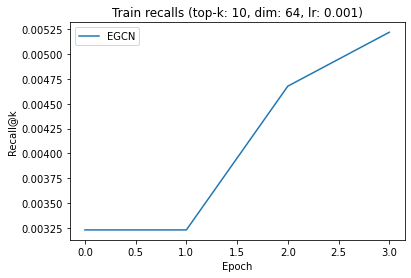

In [22]:
import matplotlib.pyplot as plt

all_epochs = list(range(len(all_train_recalls_egcn)))
fig = plt.figure()
fig.patch.set_facecolor("white")

plt.plot(all_epochs, all_train_recalls_egcn, label="EGCN")
plt.xlabel("Epoch")
plt.ylabel("Recall@k")
plt.title(f"Train recalls (top-k: {config.k}, dim: {input_dim}, lr: {config.lr})")
plt.legend()
plt.show()